# Getting started with hillmaker

In this tutorial we'll focus on basic use of hillmaker for analyzing arrivals, departures, and occupancy by time of day and day of week for a typical *discrete entity flow system*. A few examples of such systems include:

- patients arriving, undergoing some sort of care process and departing some healthcare system (e.g. emergency department, surgical recovery, nursing unit, outpatient clinic, and many more)
- customers renting, using, and returning bikes in a bike share system,
- users of licensed software checking out, using, checking back in a software license,
- products undergoing some sort of manufacturing or assembly process - occupancy is WIP,
- patrons arriving, dining and leaving a restaurant,
- travelers renting, residing in, and checking out of a hotel,
- flights taking off and arriving at their destination,
- ...

Basically, any sort of discrete [stock and flow system](https://en.wikipedia.org/wiki/Stock_and_flow) for which you are interested in time of day and day of week specific statistical summaries of occupancy, arrivals and departures, and have raw data on the arrival and departure times, is fair game for hillmaker.

## Installation

```
pip install hillmaker
```

## Ways of using hillmaker

There are currently three ways of using hillmaker. 

1. Command line interface (CLI)
2. An object oriented API in Python
3. Calling a single Python function

The plan is to add a fourth option:

4. Through a GUI interface (not implemented yet)

Depending on your level of comfort with Python, you can choose the method that works best for you. This Getting Started tutorial will demo the CLI and subsequent tutorials will show how to use Python to run hillmaker.

## Module imports
To run hillmaker we only need to import a few modules. Since the main hillmaker function uses pandas DataFrames for both data input and output, we need to import `pandas` in addition to `hillmaker`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import hillmaker as hm

In [3]:
from IPython.display import Latex

## A prototypical example - occupancy analysis of a hospital Short Stay Unit

Patients flow through a short stay unit (SSU) for a variety of procedures, tests or therapies. Let's assume patients can be classified into one of five categories of patient types: ART (arterialgram), CAT (post cardiac-cath), MYE (myelogram), IVT (IV therapy), and OTH (other). We are interested in occupancy statistics by time of day and day of week to support things like staff scheduling and capacity planning.

From one of our hospital information systems we were able to get raw data about the entry and exit times of each patient and exported the data to a csv file. We call each row of such data a *stop* (as in, the patient stopped here for a while). Let's take a peek at the data by first reading the csv file into a pandas `DataFrame`.

In [4]:
ssu_stopdata = './data/ssu_2024.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType,LOS_hours
0,1,2024-01-01 07:44:00,2024-01-01 09:20:00,IVT,1.600000
1,2,2024-01-01 08:28:00,2024-01-01 11:13:00,IVT,2.750000
2,3,2024-01-01 11:44:00,2024-01-01 12:48:00,MYE,1.066667
3,4,2024-01-01 11:51:00,2024-01-01 21:10:00,CAT,9.316667
4,5,2024-01-01 12:10:00,2024-01-01 12:57:00,IVT,0.783333


Before running hillmaker, we need to know the timeframe for which we have data. 

In [6]:
stops_df['InRoomTS'].min()

Timestamp('2024-01-01 07:44:00')

In [7]:
stops_df['InRoomTS'].max()

Timestamp('2024-09-30 22:45:00')

Looks like we have data from Jan through Sept of 2024. Since patients usually stay for less than 24 hours in an SSU, we'll do our occupancy analysis starting on January 2, 2024 (since the 1st is a holiday) and ending on September 30, 2024. Later in the tutorial we'll discuss the important issues of choosing an appropriate analysis timeframe and *horizon effects*. 

As part of an operational analysis we would like to compute a number of relevant statistics, such as:

- mean and 95th percentile of overall SSU occupancy by hour of day and day of week,
- similar hourly statistics for patient arrivals and departures,
- all of the above but by patient type as well.

In addition to tabular summaries, let's make some plots showing the mean and 95th percentile of occupancy by time of day and day of week.

## Running hillmaker via the command line interface (CLI)

To run hillmaker from the command line, make sure that you are using whatever virtual environment within which hillmaker is installed. Let's see the help for hillmaker's CLI:

In [8]:
!hillmaker -h

usage: hillmaker [--scenario_name SCENARIO_NAME]
                 [--stop_data_csv STOP_DATA_CSV] [--in_field IN_FIELD]
                 [--out_field OUT_FIELD]
                 [--start_analysis_dt START_ANALYSIS_DT]
                 [--end_analysis_dt END_ANALYSIS_DT] [--config CONFIG]
                 [--cat_field CAT_FIELD] [--bin_size_mins BIN_SIZE_MINS]
                 [--occ_weight_field OCC_WEIGHT_FIELD]
                 [--output_path OUTPUT_PATH] [--no_plots] [--xlabel XLABEL]
                 [--ylabel YLABEL] [--cap CAP] [--verbosity VERBOSITY] [-h]

Occupancy analysis by time of day and day of week

required arguments (either on command line or via config file):
  --scenario_name SCENARIO_NAME
                        Used in output filenames
  --stop_data_csv STOP_DATA_CSV
                        Path to csv file containing the stop data to be
                        processed
  --in_field IN_FIELD   Column name corresponding to the arrival times
  --out_field OUT_FIELD
 

There are several required arguments: 

- a scenario name, 
- the path to the csv file containing the stop data, 
- the field name containing the arrival times, 
- the field name containing the departure times, and start and ending dates for the analysis,
- starting and ending dates for the analysis.

There are also numerous optional arguments controlling how hillmaker works and which outputs are created.

Let's run hillmaker by specifying the required arguments as well as an output path for plots and csv files. The stop data file, `ssu_2024.csv` is in the `data` folder. We'll output plots and csv summary files to the `output` folder. Typically, we would also specify a category field - in this case it would be `PatType`. We'll use 60 minutes for the time bin size. 

In [9]:
!hillmaker --scenario cli_demo_ssu_60 --stop_data_csv ./data/ssu_2024.csv \
--in_field InRoomTS --out_field OutRoomTS --cat_field PatType --bin_size_mins 60 \
--start_analysis_dt 2024-01-02 --end_analysis_dt 2024-09-30 --output_path output --ylabel Patients 

2023-10-05 18:04:07,977 - hillmaker.hills - INFO - Starting scenario cli_demo_ssu_60 at 0.862849621
2023-10-05 18:04:07,978 - hillmaker.bydatetime - INFO - min of intime: 2024-01-01 17:25:00
2023-10-05 18:04:07,978 - hillmaker.bydatetime - INFO - max of intime: 2024-09-30 22:45:00
2023-10-05 18:04:07,978 - hillmaker.bydatetime - INFO - min of outtime: 2024-01-02 01:53:00
2023-10-05 18:04:07,978 - hillmaker.bydatetime - INFO - max of outtime: 2024-10-01 04:41:00
2023-10-05 18:04:07,978 - hillmaker.bydatetime - INFO - start analysis: 2024-01-02, end analysis: 2024-09-30
2023-10-05 18:04:07,992 - hillmaker.bydatetime - INFO - min of entry time_bin = -7
2023-10-05 18:04:07,993 - hillmaker.bydatetime - INFO - max of exit time_bin = 6556 and num_bins=6552
2023-10-05 18:04:08,208 - hillmaker.bydatetime - INFO - cat CAT {'left': 1, 'inner': 10686, 'right': 4}
2023-10-05 18:04:08,223 - hillmaker.bydatetime - INFO - cat CAT num_arrivals_hm 10690 num_arrivals_stops 10690
2023-10-05 18:04:08,223 -

By default, hillmaker prints out a bunch of informational messages. You can suppress these with `--verbosity 0`.

## csv file outputs
When you use the CLI, csv versions of the output tables are exported to `OUTPUT_PATH`.

In [10]:
!ls output/cli_demo_*.csv

output/cli_demo_ssu_60_arrivals.csv
output/cli_demo_ssu_60_arrivals_dow_binofday.csv
output/cli_demo_ssu_60_arrivals_PatType.csv
output/cli_demo_ssu_60_arrivals_PatType_dow_binofday.csv
output/cli_demo_ssu_60_bydatetime_datetime.csv
output/cli_demo_ssu_60_bydatetime_PatType_datetime.csv
output/cli_demo_ssu_60_departures.csv
output/cli_demo_ssu_60_departures_dow_binofday.csv
output/cli_demo_ssu_60_departures_PatType.csv
output/cli_demo_ssu_60_departures_PatType_dow_binofday.csv
output/cli_demo_ssu_60_occupancy.csv
output/cli_demo_ssu_60_occupancy_dow_binofday.csv
output/cli_demo_ssu_60_occupancy_PatType.csv
output/cli_demo_ssu_60_occupancy_PatType_dow_binofday.csv


There are four groups of files, each beginning with the scenario name `'cli_demo_ssu_60'`. 

- `occupancy`, `arrivals`, `departures` - summary statistics for occupancy, arrivals and departures
- `bydatetime` - number of arrivals, departures and occupancy level by datetime bin over the analysis range (e.g. individual hours on each date)

Usually it's the occupancy summaries that we are most interested in. From each occupancy related filename, we can infer the grouping levels used for the summary statistics.

### \<scenario name\>_occupancy_dow_binofday.csv

This is probably the most used summary as it gives us overall occupancy statistics by time bin of day (in this case, hourly) and day of week. We can read it into a pandas `DataFrame` and take a look. Since we used hourly time bins, there will be 168 rows in the summary. Numerous summary statistics are computed for each hour of the week.

In [11]:
occ_dow_binofday_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_dow_binofday.csv')
occ_dow_binofday_df.head(30)


,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,0,Mon,0,00:00,39.0,1.561966,0.000000,4.666667,1.337969,0.214246,1.790160,0.856593,0.863336,-0.009379,0.533333,1.000000,2.000000,4.353333,4.616000
1,0,Mon,1,01:00,39.0,1.530342,0.000000,5.000000,1.314454,0.210481,1.727791,0.858929,1.123432,0.861793,0.783333,1.000000,2.000000,4.450000,4.905000
2,0,Mon,2,02:00,39.0,1.364103,0.000000,4.950000,1.194374,0.191253,1.426528,0.875575,1.089267,1.091913,0.950000,1.000000,2.000000,3.578333,4.582667
3,0,Mon,3,03:00,39.0,1.232479,0.000000,4.400000,1.058411,0.169481,1.120233,0.858766,0.875510,0.792365,0.350000,1.000000,1.991667,3.040000,4.020000
4,0,Mon,4,04:00,39.0,1.076068,0.000000,3.900000,0.971568,0.155575,0.943944,0.902887,0.893486,0.663040,0.000000,1.000000,1.600000,2.940000,3.558000
5,0,Mon,5,05:00,39.0,2.229915,0.083333,4.700000,1.138399,0.182290,1.295953,0.510513,0.442054,-0.335741,1.508333,2.000000,2.691667,4.178333,4.598667
6,0,Mon,6,06:00,39.0,15.443162,0.333333,21.483333,3.931664,0.629570,15.457978,0.254589,-2.423603,7.778248,14.616667,16.083333,17.241667,19.630000,21.166667
7,0,Mon,7,07:00,39.0,29.869658,1.533333,38.966667,7.498266,1.200683,56.223989,0.251033,-2.669468,8.294117,28.625000,31.433333,33.708333,36.283333,38.346000
8,0,Mon,8,08:00,39.0,39.738889,1.683333,56.650000,10.724470,1.717290,115.014259,0.269873,-2.304590,6.600737,36.925000,42.650000,45.366667,49.335000,54.218000
9,0,Mon,9,09:00,39.0,58.750000,1.483333,79.116667,15.509799,2.483556,240.553874,0.263997,-2.538838,7.735264,57.241667,61.283333,66.858333,74.036667,77.311667


From the `count` field we can see that there were 39 Mondays in the analysis date range. It is this `DataFrame` that used to create the weekly and day of week plots.

In [12]:
!ls output/*occupancy*.png

output/cli_demo_ssu_60_occupancy_fri.png
output/cli_demo_ssu_60_occupancy_mon.png
output/cli_demo_ssu_60_occupancy_sat.png
output/cli_demo_ssu_60_occupancy_sun.png
output/cli_demo_ssu_60_occupancy_thu.png
output/cli_demo_ssu_60_occupancy_tue.png
output/cli_demo_ssu_60_occupancy_wed.png
output/cli_demo_ssu_60_occupancy_week.png


In [13]:
from IPython.display import Image

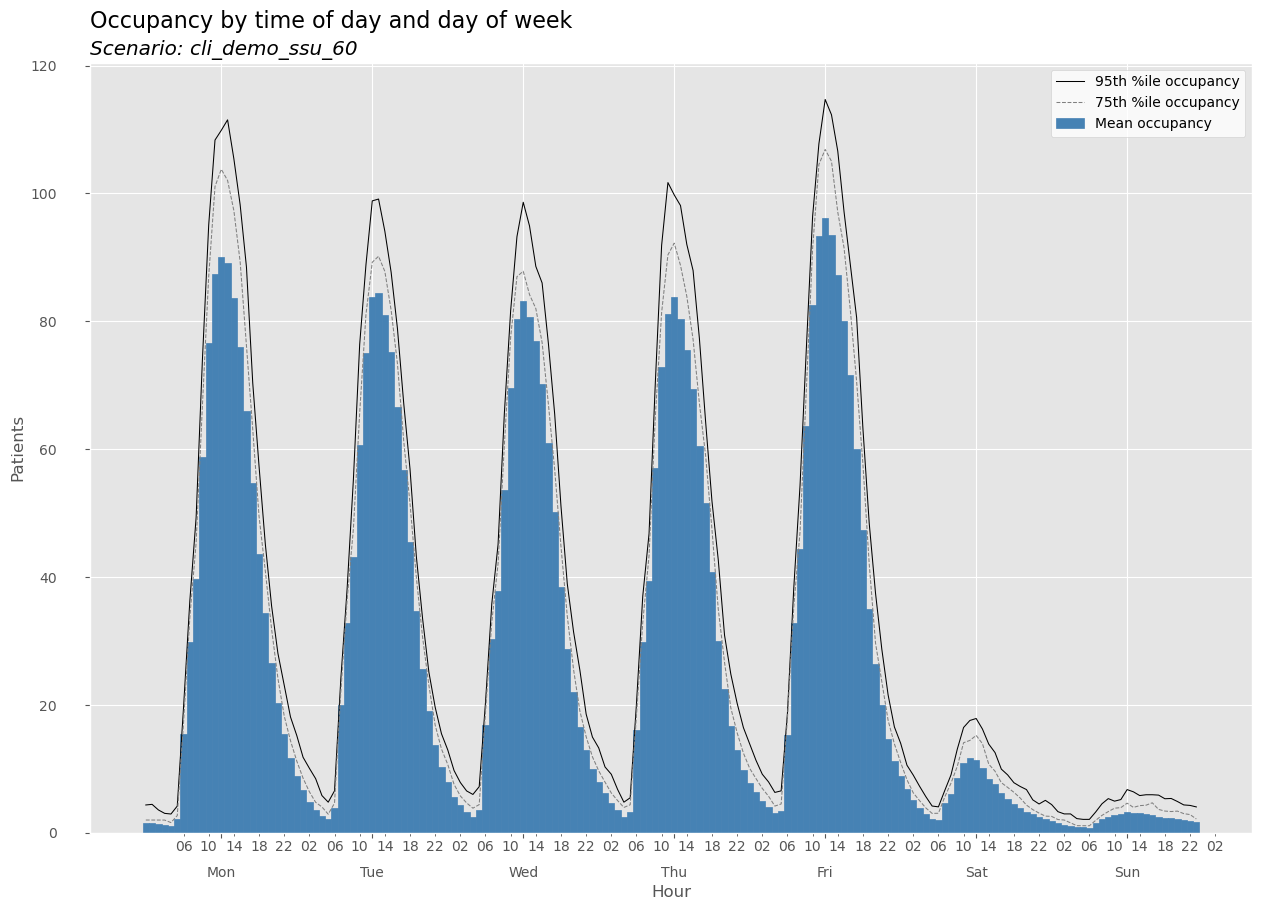

In [14]:
Image('output/cli_demo_ssu_60_occupancy_week.png')

There are also day of week specific plots.

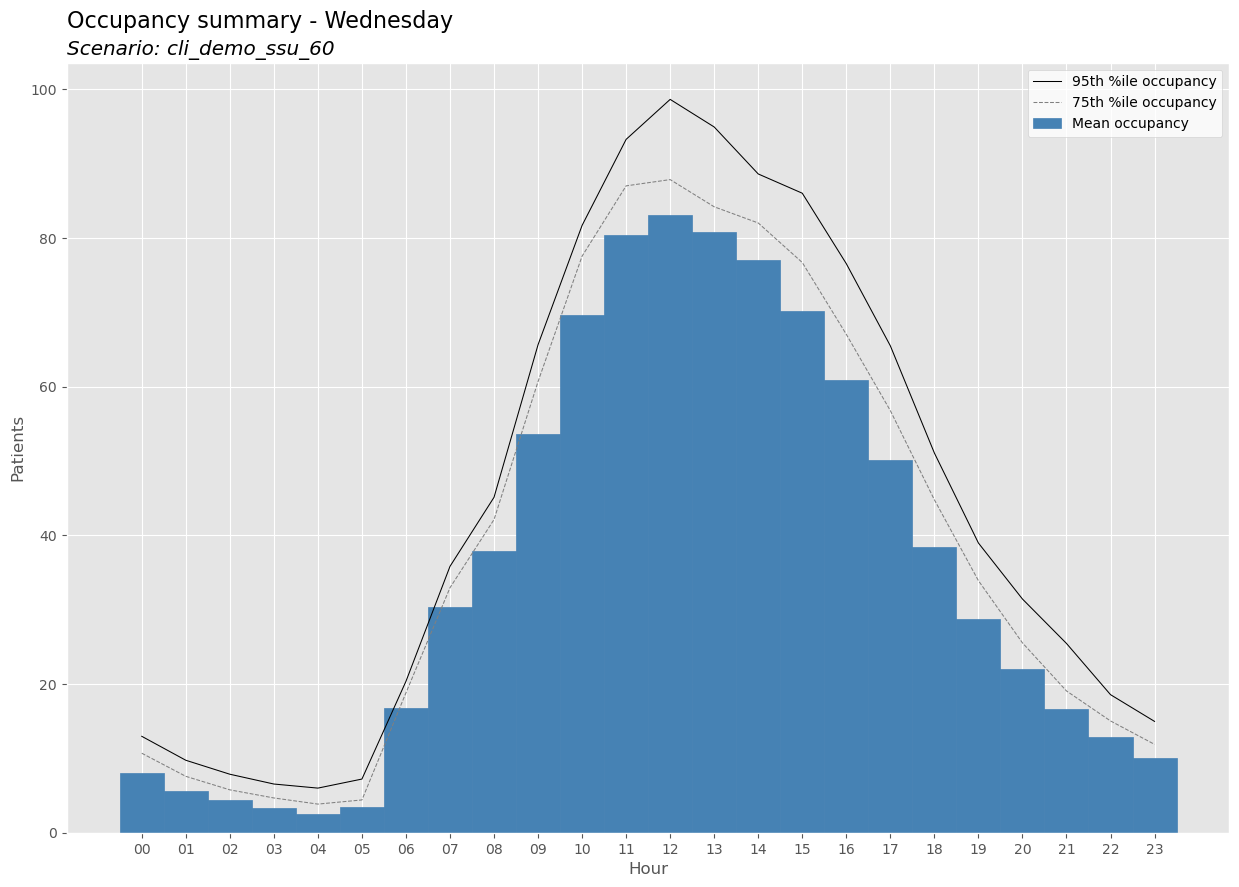

In [15]:
Image('output/cli_demo_ssu_60_occupancy_wed.png')

### cli_demo_ssu_occupancy_PatType_dow_binofday.csv

This is the most detailed summary as it is grouped by patient type, day of week and hour of day.  This `DataFrame` is useful for seeing how individual patient types contribute to overall occupancy in the SSU. 


In [16]:
occ_PatType_dow_binofday_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_PatType_dow_binofday.csv')
occ_PatType_dow_binofday_df


,PatType,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,ART,0,Mon,0,00:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ART,0,Mon,1,01:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ART,0,Mon,2,02:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ART,0,Mon,3,03:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ART,0,Mon,4,04:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,OTH,6,Sun,19,19:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,OTH,6,Sun,20,20:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,OTH,6,Sun,21,21:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
838,OTH,6,Sun,22,22:00,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The other two occupancy related csv files are summaries aggregated over time. One, `cli_demo_ssu_60_occupancy_PatType.csv`, is grouped by the category field and the other, `cli_demo_ssu_60_occupancy.csv`, is aggregated both over time and category.


In [17]:
occ_PatType_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_PatType.csv')
occ_PatType_df


,PatType,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,ART,6552.0,3.498013,0.0,22.400000,5.156624,0.063706,26.590766,1.474158,1.250915,0.230793,0.000000,0.000000,6.950000,14.250000,17.565667
1,CAT,6552.0,8.048838,0.0,34.383333,7.812497,0.096517,61.035116,0.970637,0.912114,-0.259791,1.616667,4.983333,13.716667,23.290833,28.274167
2,IVT,6552.0,10.076318,0.0,54.733333,13.459828,0.166285,181.166964,1.335788,1.205648,0.088333,0.033333,2.283333,18.408333,38.200000,45.500000
3,MYE,6552.0,1.971853,0.0,13.483333,2.902841,0.035862,8.426486,1.472138,1.364864,0.662152,0.000000,0.000000,3.533333,8.216667,10.308167
4,OTH,6552.0,4.567918,0.0,27.000000,5.687160,0.070260,32.343793,1.245022,1.072276,0.039763,0.000000,1.550000,8.533333,15.866667,19.891500


In [18]:
occ_df = pd.read_csv('output/cli_demo_ssu_60_occupancy.csv')
occ_df


,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,6552.0,28.16294,0.0,121.533333,31.066525,0.383801,965.128949,1.103099,0.976111,-0.409349,3.316667,12.525,50.266667,89.83,105.0575


### The bydatetime files
The remaining csv files provided detailed occupancy, arrival and departures values for every time bin over the entire analysis range. For example, here's what `cli_demo_ssu_60_bydatetime_datetime.csv` looks like.

In [19]:
bydatetime_df = pd.read_csv('output/cli_demo_ssu_60_bydatetime_datetime.csv')
bydatetime_df.head(30)


,datetime,arrivals,departures,occupancy,dow_name,bin_of_day_str,day_of_week,bin_of_day,bin_of_week
0,2024-01-02 00:00:00,0.0,0.0,1.000000,Tue,00:00,1,0,24
1,2024-01-02 01:00:00,0.0,1.0,0.883333,Tue,01:00,1,1,25
2,2024-01-02 02:00:00,0.0,0.0,0.000000,Tue,02:00,1,2,26
3,2024-01-02 03:00:00,0.0,0.0,0.000000,Tue,03:00,1,3,27
4,2024-01-02 04:00:00,0.0,0.0,0.000000,Tue,04:00,1,4,28
5,2024-01-02 05:00:00,0.0,0.0,0.000000,Tue,05:00,1,5,29
6,2024-01-02 06:00:00,6.0,0.0,1.983333,Tue,06:00,1,6,30
7,2024-01-02 07:00:00,16.0,1.0,12.650000,Tue,07:00,1,7,31
8,2024-01-02 08:00:00,11.0,5.0,24.283333,Tue,08:00,1,8,32
9,2024-01-02 09:00:00,25.0,3.0,35.350000,Tue,09:00,1,9,33


Notice that the occupancy field contains non-integer values. This is by design. For now, it is enough to say that occupancy in each time bin is proportional to the time a patient spent in the system. For example, if a patient arrives at 7:15a and departs at 9:30a, then their contribution to occupancy in the `bydatetime` dataframe is:

- 7a-8a:  0.75
- 8a-9a:  1.00
- 9a-10a: 0.50

For all the details on how hillmaker computes occupancy and options for controlling those computations, see {doc}`topic guide on occupancy computation <computing_occupancy.ipynb>`.

## Using the `make_hills` function

Before the creation of the object-oriented API, hillmaker could be used by calling a single, module level, function called `make_hills`. This type of legacy use is still possible. The `make_hills` function returns the same `hills` dictionary we just saw with the OO API but can also create and export plots and dataframes via function arguments. We'll use the same example but will use two-hour time bins. 

Like the CLI, the legacy `make_hills` function creates and exports all plots as well the dataframes as CSV files. This behavior can be more finely controlled through input arguments. See {doc}`using_make_hills` for all the details.


2023-10-06 08:30:05,119 - hillmaker.hills - INFO - Starting scenario func_demo_ssu_120 at 49.079408326
2023-10-06 08:30:05,124 - hillmaker.bydatetime - INFO - min of intime: 2024-01-01 17:25:00
2023-10-06 08:30:05,126 - hillmaker.bydatetime - INFO - max of intime: 2024-09-30 22:45:00
2023-10-06 08:30:05,127 - hillmaker.bydatetime - INFO - min of outtime: 2024-01-02 01:53:00
2023-10-06 08:30:05,128 - hillmaker.bydatetime - INFO - max of outtime: 2024-10-01 04:41:00
2023-10-06 08:30:05,130 - hillmaker.bydatetime - INFO - start analysis: 2024-01-02, end analysis: 2024-09-30
2023-10-06 08:30:05,168 - hillmaker.bydatetime - INFO - min of entry time_bin = -4
2023-10-06 08:30:05,173 - hillmaker.bydatetime - INFO - max of exit time_bin = 3278 and num_bins=3276
2023-10-06 08:30:05,756 - hillmaker.bydatetime - INFO - cat CAT {'left': 1, 'inner': 10686, 'right': 4}
2023-10-06 08:30:05,774 - hillmaker.bydatetime - INFO - cat CAT num_arrivals_hm 10690 num_arrivals_stops 10690
2023-10-06 08:30:05,77

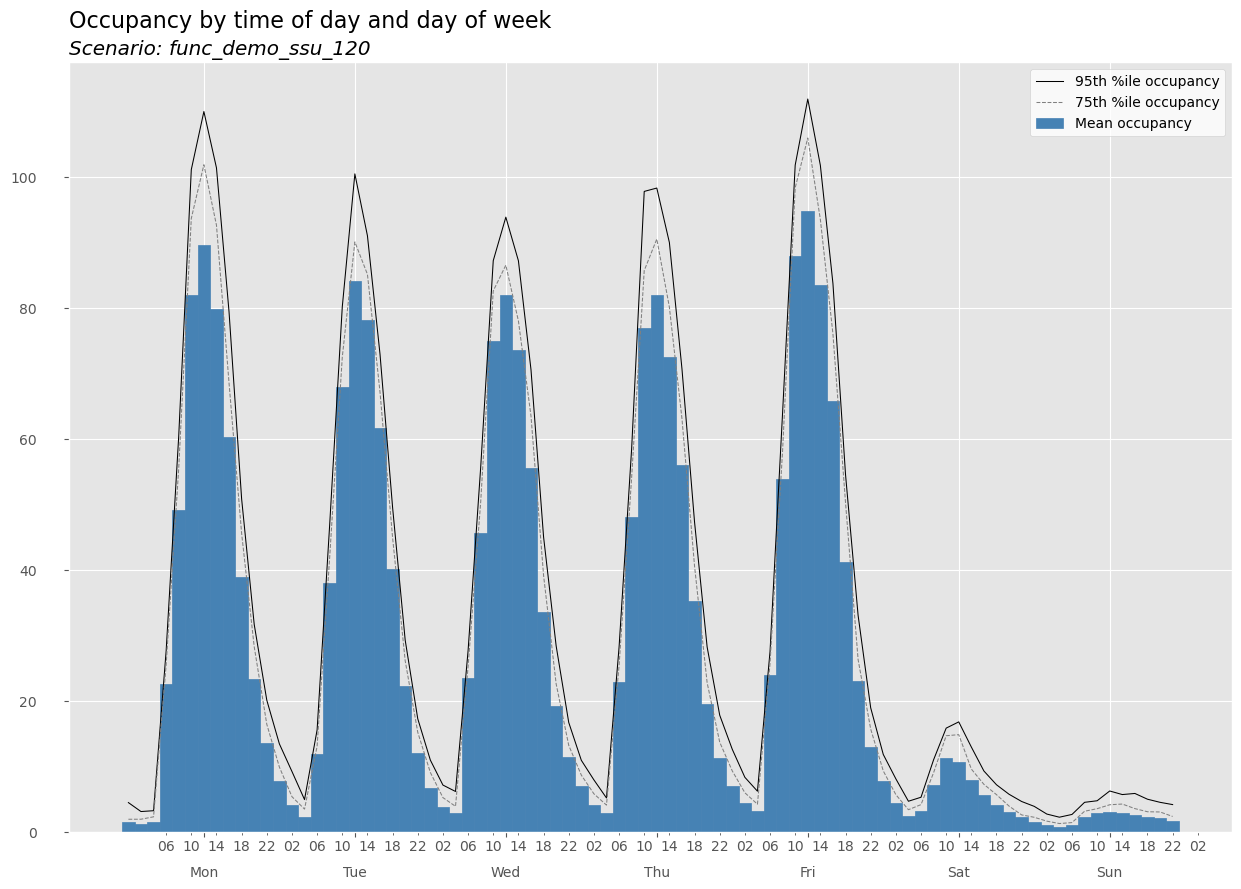

In [14]:
# Required inputs
scenario_name = 'func_demo_ssu_120'
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '2024-01-02'
end_date = '2024-09-30'

# Optional inputs
cat_field_name = 'PatType'
verbosity = 1  # INFO level logging
output_path = './output'
bin_size_minutes = 120

# Use legacy function interface
hills = hm.make_hills(scenario_name=scenario_name, stops_df=stops_df,
              in_field=in_field_name, out_field=out_field_name,
              start_analysis_dt=start_date, end_analysis_dt=end_date,
              cat_field=cat_field_name,
              bin_size_minutes=bin_size_minutes,
              output_path='./output', verbosity=verbosity)

# Get and display occupancy plot
occ_plot = hm.get_plot(hills, 'occupancy')
occ_plot

\begin{center}
\begin{tabular}{ |c|c| } 
 \hline
 7a-8a & 0.75 \\ 
 8a-9a & 1.00 \\ 
 9a-10a & 0.50 \\ 
 \hline
\end{tabular}
\end{center}

## Using the object oriented hillmaker API

For more control over hillmaker you can use the object oriented API. In this tutorial we'll just do a brief introduction. You can get more details in {doc}`using_oo_api`.

The main steps in using the API are:

- create a `Scenario` object initialized with your hillmaker inputs,
- call the `make_hills` method to run hillmaker and store the outputs in the `Scenario` object,
- use methods to retrieve `Dataframe` objects, plots and other outputs

Here's a brief example. We'll use the same inputs as in the first example, except for changing `bin_size_minutes` to 30. We can use `stops_df` as our input `Dataframe`. By default, plots aren't automatically created or exported. We will use the `export_all_week_plots` argument to create and export just the weekly plots. There are a number of other input arguments that can be used for more detailed control of the hillmaker analysis process, but we'll hold off on that for now.

In [5]:
oo_demo_ssu_30 = hm.Scenario(scenario_name='oo_demo_ssu_30',
                             stops_df=stops_df,
                             in_field='InRoomTS',
                             out_field='OutRoomTS',
                             start_analysis_dt='2024-01-02',
                             end_analysis_dt='2024-09-30',
                             cat_field='PatType',
                             bin_size_minutes=30,
                             output_path='./output',
                             export_all_week_plots=True)

Let's make some hills.

In [6]:
oo_demo_ssu_30.make_hills()

All of the outputs from running `make_hills` get stored in an attribute dictionary called `hills`.

In [7]:
oo_demo_ssu_30.hills.keys()

dict_keys(['bydatetime', 'summaries', 'length_of_stay', 'settings', 'plots', 'runtime'])

There are methods for retrieving specific items from this dictionary. For example, there is `get_plot`.

In [8]:
oo_demo_ssu_30.get_plot?

Signature:
oo_demo_ssu_30.get_plot(
    flow_metric: str = 'occupancy',
    day_of_week: str = 'week',
)
Docstring:
Get plot object for specified flow metric and whether full week or specified day of week.

Parameters
----------
flow_metric : str
    Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
    Default='occupancy'
day_of_week : str
    Either of 'week', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'. Default='week'

Returns
-------
plot object from matplotlib
File:      ~/Documents/projects/hillmaker/src/hillmaker/scenario.py
Type:      method

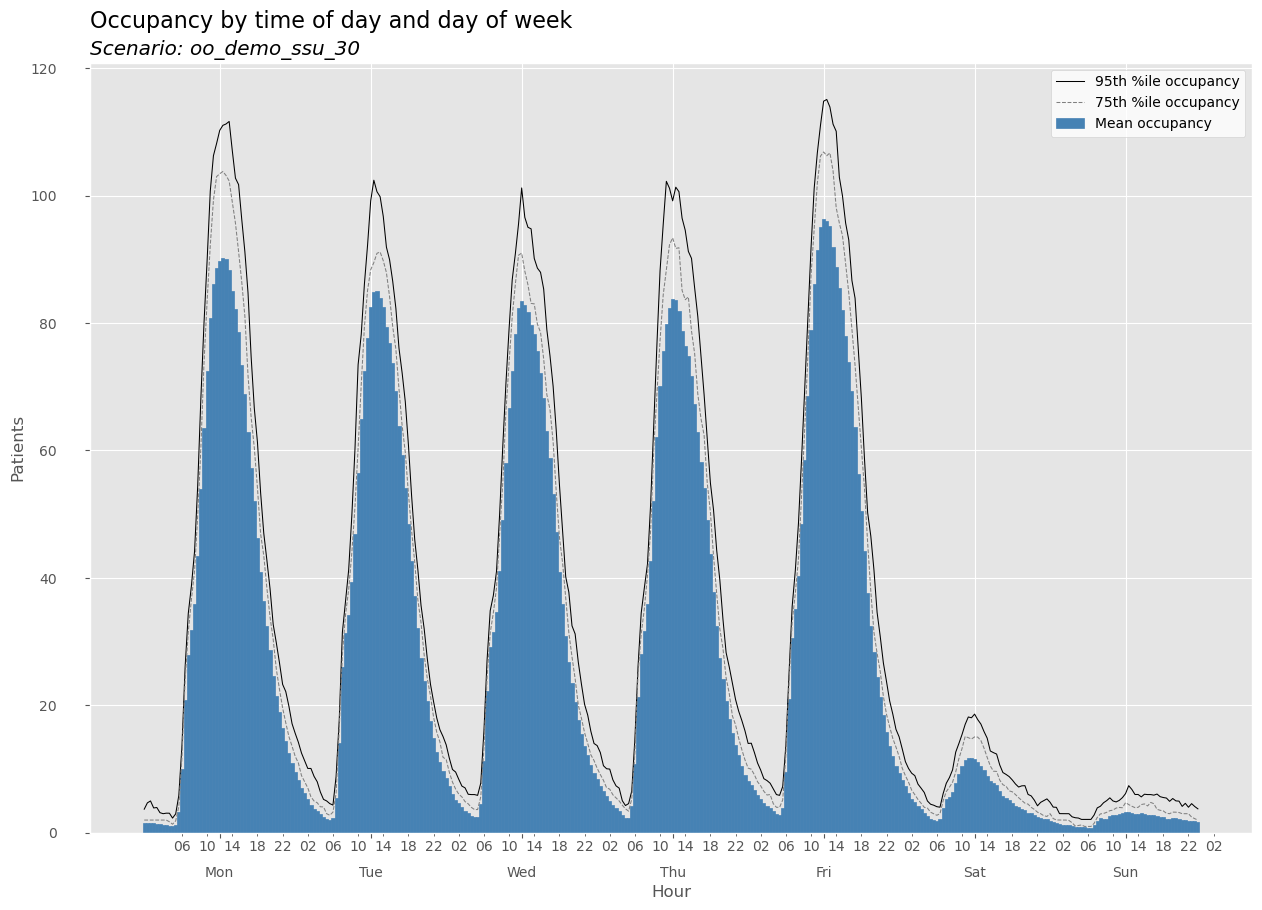

In [10]:
oo_demo_ssu_30.get_plot('occupancy')

See {doc}`using_oo_api` for all the details on using the API.